In [20]:
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace, entropy
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit.extensions import UnitaryGate
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from qiskit.test.reference_circuits import ReferenceCircuits
from qiskit.transpiler import CouplingMap

In [4]:

# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b58a80862cd6d4e3f8618d0fb10c85a7415315bcf55dd407e498ce33bdd4709623e266b4fdee952700733135cd2fa847c7bffa65966a4efb0aa2ae6a4ad7b583", overwrite=True)

In [186]:
#Here we generate the ground state for some parameter choice and then we put it in the qc to see if we manage to measure
#EE at the critical point and if it matches predictions for central charge
import numpy as np
#from scipy.sparse import lil_matrix
from scipy.sparse.linalg import eigsh



def ising_hamiltonian(n, J, h):
    
    sigmaz=np.array([[1, 0], [0, -1]])
    
    # Initialize the Hamiltonian matrix as a sparse lil_matrix
    hamiltonian = np.zeros((2**n, 2**n), dtype=complex)
    sigmazij=np.kron(sigmaz,sigmaz)
    
    for i in range(1,n+1):
        
        if i==(n):
            hamiltonian += -J * np.kron(sigmaz,np.eye(2**(n-1)))@np.kron(np.eye(2**(n-1)),sigmaz)
            print("done")
            break
        
        hamiltonian += -J * np.kron((np.kron(np.eye(2**(i-1)),sigmazij)),np.eye(2**(n - i - 1)))
        
    print('----')
    for i in range(1,n+1):
        # Term for the transverse field h * sigma_i^x
        hamiltonian += -h * np.kron(np.kron(np.eye(2**(i-1)), np.array([[0, 1], [1, 0]])), np.eye(2**(n - i)))
        
    return hamiltonian



In [187]:
print(ising_hamiltonian(2,2,2))

done
----
[[-4.+0.j -2.+0.j -2.+0.j  0.+0.j]
 [-2.+0.j  4.+0.j  0.+0.j -2.+0.j]
 [-2.+0.j  0.+0.j  4.+0.j -2.+0.j]
 [ 0.+0.j -2.+0.j -2.+0.j -4.+0.j]]


In [189]:
J,h=2,2
sigmaz=np.array([[1, 0], [0, -1]])
ide=np.array([[1, 0], [0, 1]])
sigmax=np.array([[0, 1], [1, 0]])
sigmaz12=np.kron(sigmaz,sigmaz)
#sigmaz21=np.kron(sigmaz,sigmaz)
sigmax1=np.kron(sigmax,ide)
sigmax2=np.kron(ide,sigmax)
ham=-J*(sigmaz12+sigmaz21)-h*(sigmax1+sigmax2)
print(ham)
#print(np.kron(sigmaz,ide)@np.kron(ide,sigmaz))
#print(np.kron(ide,sigmaz)@np.kron(sigmaz,ide))
np.allclose(ham,ising_hamiltonian(2,2,2))

[[-4 -2 -2  0]
 [-2  4  0 -2]
 [-2  0  4 -2]
 [ 0 -2 -2 -4]]
done
----


True

In [211]:
#VARYING BIPARTITION
# Define the parameters for the Ising model
n = 8 # Number of sites
J = 1.05  # Interaction strength
h = 1.0  # Transverse field strength
h_array=np.array([1e-9,0.5,1,1.5,2])




entropies = np.zeros((len(h_array),n),dtype=complex)
renyi = np.zeros((len(h_array),n),dtype=complex)

for i,h in enumerate(h_array):
    print(h,i)
    hamiltonian = ising_hamiltonian(n, J, h)
    
    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian)

    order=np.argsort(eigenvalues)
    
    #find lowest eigenvector
    gs = eigenvectors[:, order[0]]
    
    
    # Compute the full density matrix
    density_matrix = (1/np.linalg.norm(np.outer(gs,gs.conj().T)))*np.outer(gs,gs.conj().T)
    
    for m in tqdm(range(0,n)):
        subsystem = [j for j in range(m+1)]  # Adjust these indices as needed
        #print(subsystem)
        #Here we have to take the partial trace with respect to the bipartition,
        #we do this by constructing the full density matrix and then we trace out 
        #IT SEEMS LIKE IT WORKS NOW, WE JUST NEED TO IMPLEMENT SPARSE ARRAY FOR THE 
        #DEFINITION OF ISING TO ALLOW FOR BIGGER SYSTEM SIZES
        
        # there should be something like qiskit.partial_trace(density_matrix,trace_systems=subsystem), use it 
        reduced_rho = partial_trace(density_matrix, subsystem)
        
        # Find the eigenvalues of the reduced density matrix
        eigenvalues, _ = np.linalg.eig(reduced_rho)
        
        
        # Compute the entanglement entropy
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        #print(entanglement_entropy)
        entropies[i,m]=entanglement_entropy
        renyi[i,m]=-np.log(DensityMatrix.purity(reduced_rho))
        #print("Entanglement Entropy:", entanglement_entropy)
       
    

1e-09 0
done
----


  0%|                                                                                     | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_121/2440107474.py:49: RuntimeWarning: divide by zero encountered in log
  entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
/tmp/ipykernel_121/2440107474.py:49: RuntimeWarning: invalid value encountered in multiply
  entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
100%|████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 192.09it/s]


0.5 1
done
----


100%|████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 165.19it/s]


1.0 2
done
----


100%|█████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 88.55it/s]


1.5 3
done
----


100%|████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 158.94it/s]


2.0 4
done
----


100%|████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 166.49it/s]


2


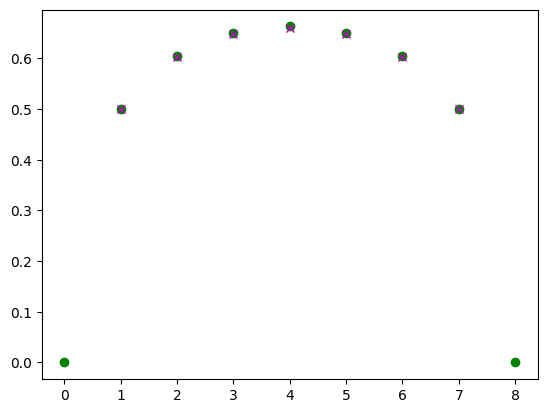

In [221]:
#Central charge fitting 

bipart = [m for m in range(0,n+1)]
bip = [m for m in range(1,n)]
c=.5
A=0.505
for i in range(2,3):
    print(i)
    #plt.plot(bipart,np.concatenate(([1e-15],renyi[i]))/np.log(2),'x')
    plt.plot(bipart,np.concatenate(([1e-15],entropies[i])),'o',c='g')
for i in range(len(bip)):
    plt.plot(bip[i],(c/3)*np.log((n/np.pi)*np.sin((np.pi*bip[i])/n)) + A,'x',c='m')

0
1
2
3
4


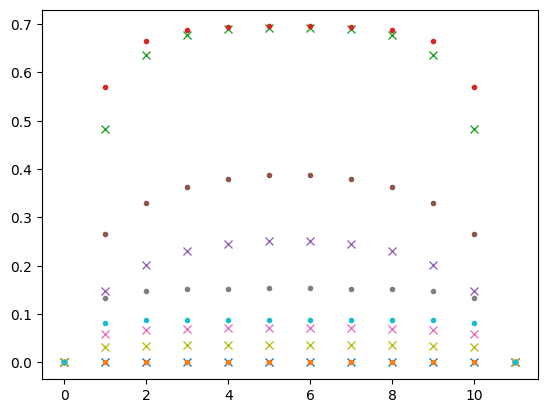

In [17]:
for i in range(0,5):
    print(i)
    plt.plot([m for m in range(0,n+1)],np.concatenate(([1e-15],renyi[i])),'x')
    plt.plot([m for m in range(0,n+1)],np.concatenate(([1e-15],entropies[i])),'.')

In [12]:
from scipy.optimize import curve_fit


def my_curve_function(x, a,b):
   
    return a*k**2 + b

params, covariance = curve_fit(my_curve_function,xdata_exp,ydata_exp)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

[0.89063517]


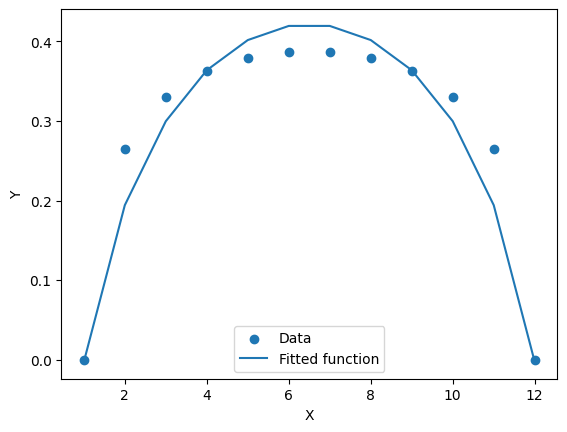

In [87]:
x_data = np.array([m for m in range(1, n+2)])
y_data = np.concatenate(([1e-15], entropies))  # Assuming entropies is a NumPy array

# Fit the curve
params = curve_fit(my_curve_function, x_data, y_data)
 # Extract the fitted parameter 'c'

# Create the best-fit curve
#y_fit = my_curve_function(x_data, c_fit)
print(params[0])
# Plot the data and the best-fit curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, my_curve_function(x_data, params[0]),
         label='Fitted function')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [81]:
print(n)
print([m for m in range(1, n)])
print(my_curve_function(x_data, params[0]))

11
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[-4.54388370e-03  2.12721748e-01  3.24373393e-01  3.86150075e-01
  4.14311558e-01  4.14311558e-01  3.86150075e-01  3.24373393e-01
  2.12721748e-01 -4.54388370e-03 -1.12845980e+01             nan]


/tmp/ipykernel_182/2178718579.py:6: RuntimeWarning: invalid value encountered in log
  return(c/3)*np.log((n/np.pi)*np.sin((np.pi*x)/n))


Optimization levels (Error Suppression):
    3 = Dynamical Decoupling 
    
Mitigation levels (Error mitigation):
    1 = T-REx (twirled readout extinction)
    2 = ZNE (zero-noise extrapolation)
    3 = PEC (probability error cancellation)


Typical call to job:

service = QiskitRuntimeService(channel="ibm_quantum")
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # optimization
options.resilience_level = 0  # mitigation

with Session(service=service, backend=backend_simulator) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_sim.job_id)
    print(job_sim.result())

In [4]:


#need to specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("simulator_statevector")


In [5]:
def generate_pauli(n, i, j):
    if n <= 0 or i < 0 or j < 0 or i >= n or j >= n:
        raise ValueError("Invalid input values")
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i and j
    pauli_str_list = list(pauli_str)
    pauli_str_list[i] = "Z"
    pauli_str_list[j] = "Z"
    pauli_str = "".join(pauli_str_list)
    op1 = SparsePauliOp(pauli_str, coeffs=[1])
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i
    pauli_str_list = list(pauli_str)
    pauli_str_list[i] = "Z"
    pauli_str = "".join(pauli_str_list)
    op2 = SparsePauliOp(pauli_str, coeffs=[1])
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position j
    pauli_str_list = list(pauli_str)
    pauli_str_list[j] = "Z"
    pauli_str = "".join(pauli_str_list)
    op3 = SparsePauliOp(pauli_str, coeffs=[1])

    

    return op1,op2,op3

In [6]:
#Circuit parameters
n=8
h=1
J=1.1
tau=0.1
m=0
layers=20
k=1
#Initialize qcirc and qstate
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,'11111111',[0,1,2,3,4,5,6,7])
sigma_z= np.array([[1,0],[0,-1]])
#prepare ancilla
#qc.h(0)
#creation of controlled unitary
cu_gate = UnitaryGate(sigma_z, label='CU') #this gate will have to be the whole evolution circuit 

# Apply the controlled unitary operation with control qubit 0 and target qubit 1
#qc.append(cu_gate.control(), [0, 1])
qc.barrier(range(n))
#anti-controlled operation



while m<layers:
    for i in range(n):
        qc.rx(tau*h,i)
    for j in range(n//2):
        qc.rzz(tau*J, 2*j,2*j+1)
    for j in range(n//2):
        if j == (n/2 - 1):
                break
        qc.rzz(tau*J, 2*j+1,2*j+2)
    qc.barrier(range(n))
    m+=1
    
    
anti_gate = cu_gate.control(ctrl_state='0')
#qc.append(anti_gate, [0, j+1])
qc.barrier(range(n))

basis_gates=['cx', 'id', 'rz', 'x', 'sx']
qcc=transpile(qc, basis_gates=basis_gates, optimization_level=3)

In [206]:
#settings job execution
service = QiskitRuntimeService(channel="ibm_quantum")
options = Options()
options.execution.shots = 8000
options.optimization_level = 3  # optimization
options.resilience_level = 2  # mitigation

#coupling map for Simulator 
cmap = CouplingMap()
for i in range(n):
    if i == n-1:
        cmap.add_edge(n-1,0)
    else:
        cmap.add_edge(i, i + 1)
    

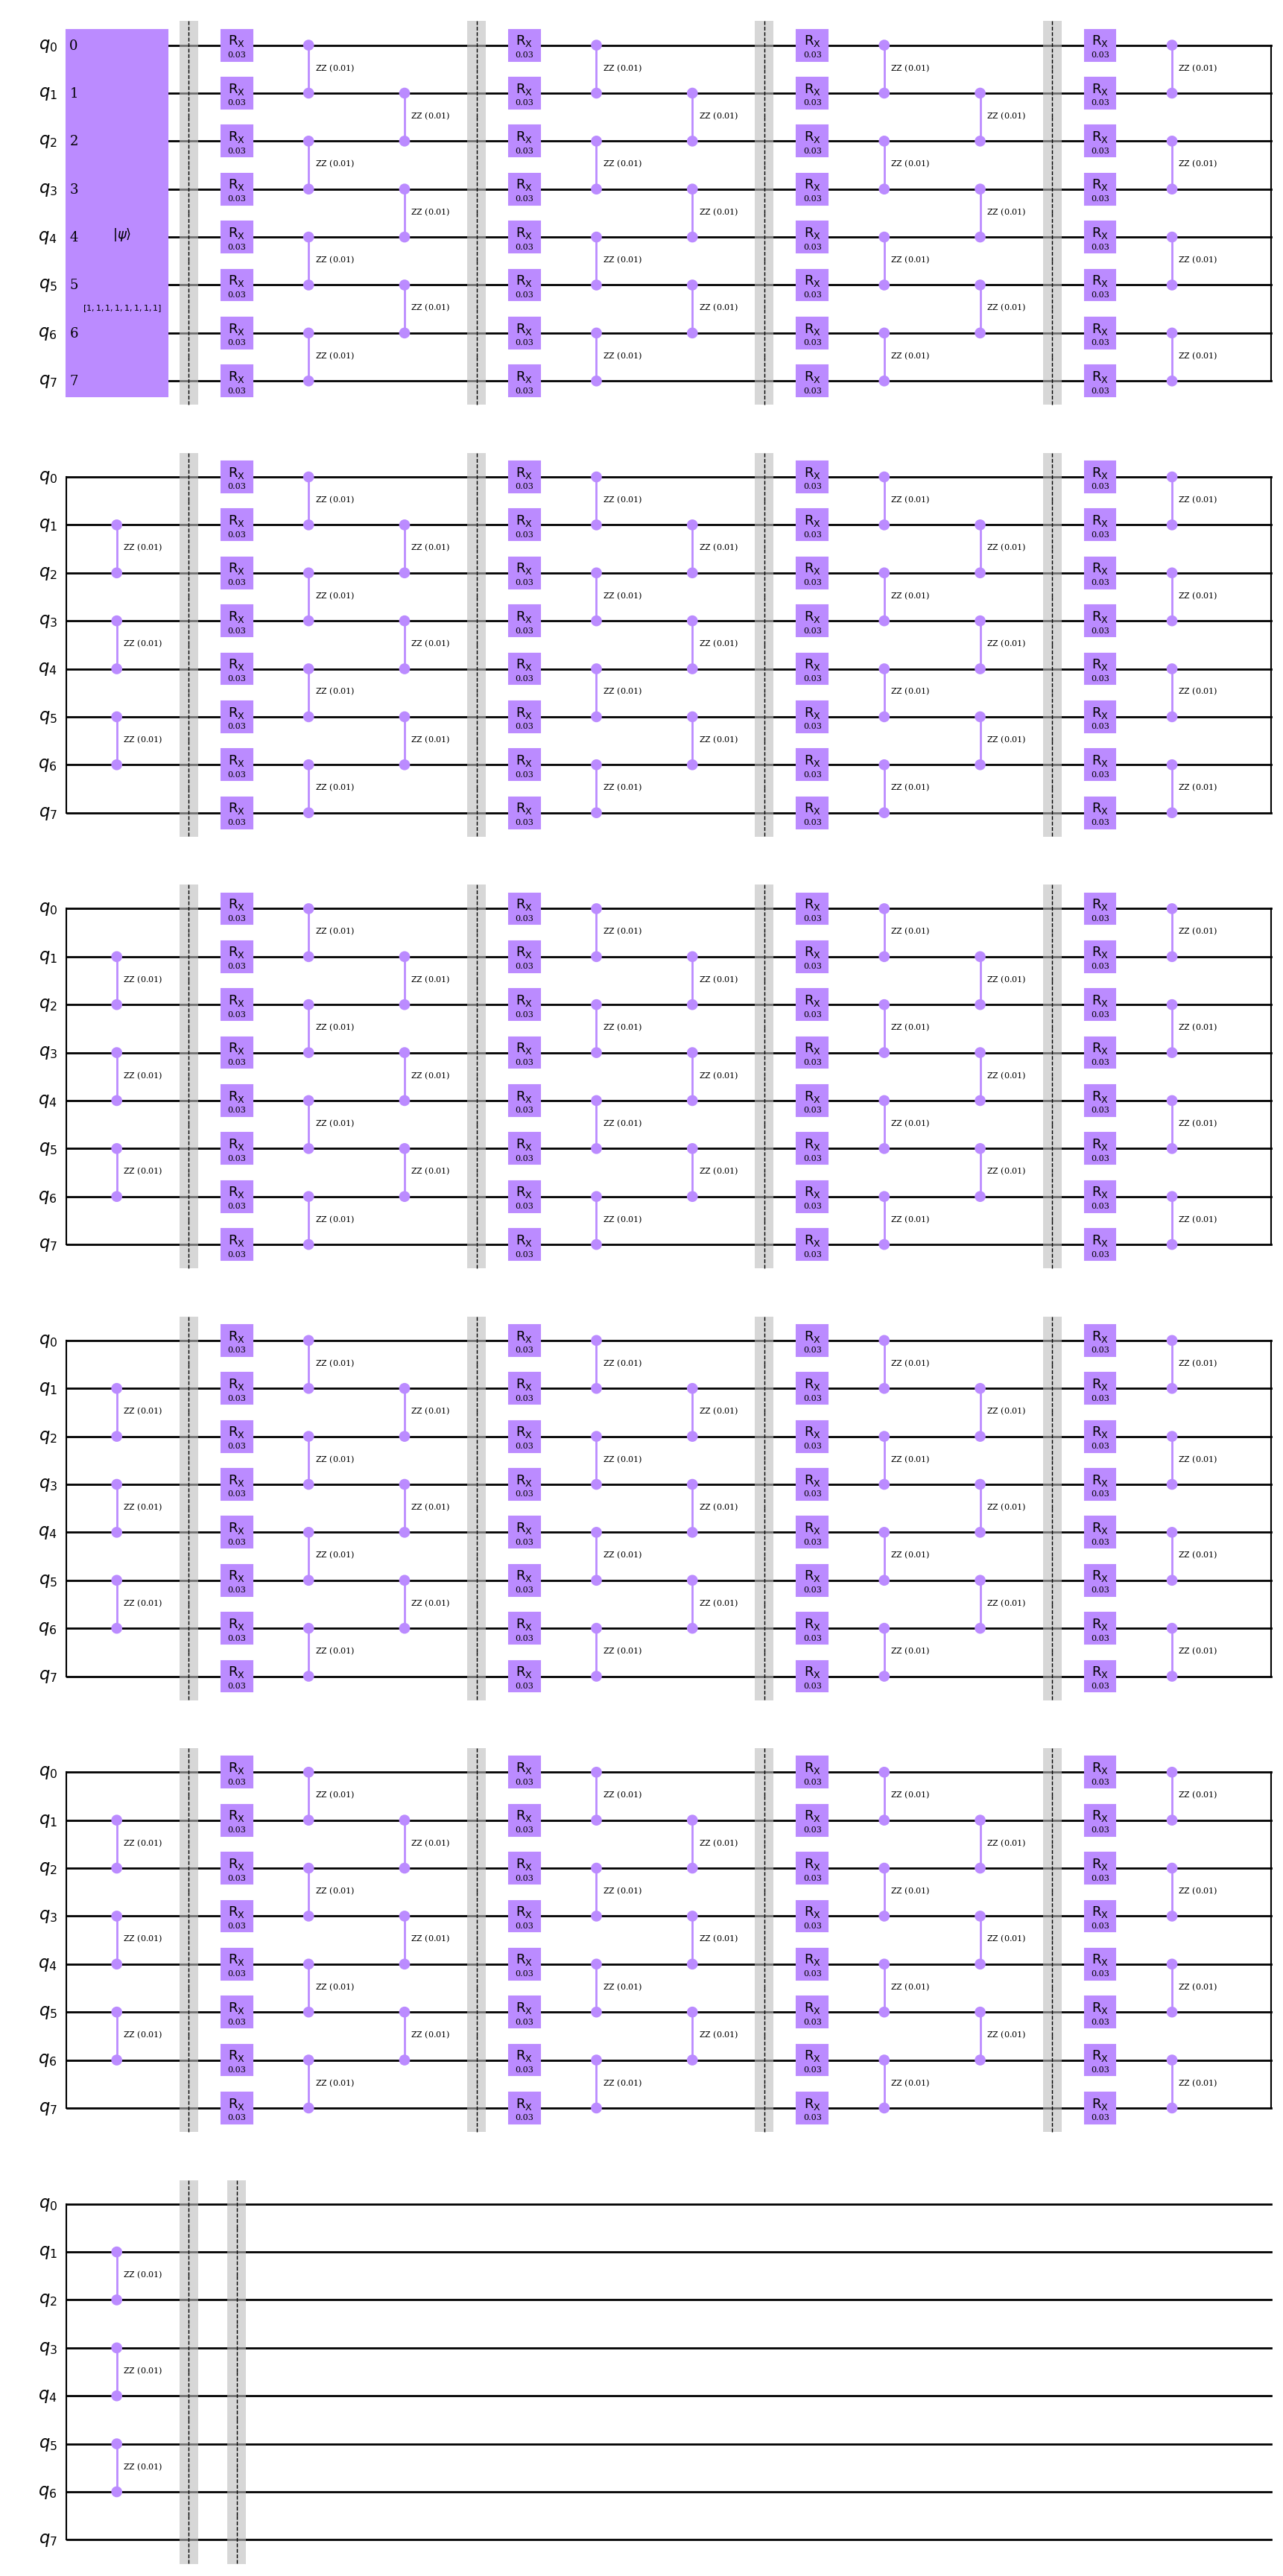

In [231]:
dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

In [32]:
def entropyscaling(qc,n):
    entropylist = np.zeros(n)
    for l in range(0,n):
        #print(l,n-l)
        rho = DensityMatrix(qcc)
        rho_a=partial_trace(rho, range(0,l))
        entropylist[l]=entropy(rho_a)
        #print(entropy(rho_a))
    return entropylist

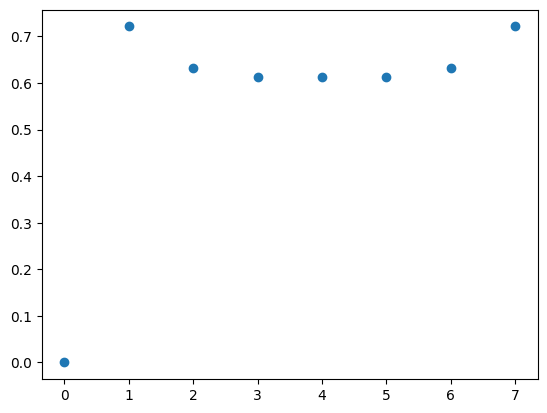

In [34]:
plt.scatter([l for l in range(0,n)],entropylist)

100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:59<00:00, 42.81s/it]


Text(0.5, 1.0, 'TFIM Spatial Correlation $C_{ij}(r)$, h=1, J=1.1, layers=20')

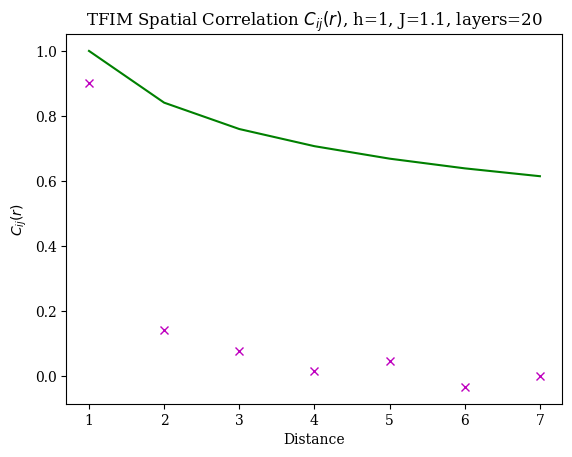

In [240]:
#computation of spatial correlation functions for incresing distance
correlations = np.zeros(n-1,dtype=complex)
for m in tqdm(range(1,n)):
    op1,op2,op3 = generate_pauli(n, 0, m)
    with Session(service=service, backend=backend) as session:
        estimator_sim = Estimator(session=session, options=options)
        job_sim = estimator_sim.run(circuits=[qcc]*3, observables=[op1,op2,op3], coupling_map=cmap)
        values = job_sim.result().values
        correlations[m-1]=2*values[0]-values[1]*values[2]
distances=np.array([i for i in range(1,8)], dtype=float)
plt.plot(distances, correlations,'x', c='m')
plt.plot(distances, 1/distances**(1/4),c='g')
plt.rcParams["font.family"] = "serif"
plt.xlabel(r'Distance')
plt.ylabel(r'$C_{ij}(r)$')
plt.title(r"TFIM Spatial Correlation $C_{ij}(r)$, h="+str(h)+", J="+str(J)+", layers="+str(layers))
#plt.savefig("TFIM Spatial Correlation $C_{ij}(r)$, h="+str(h)+", J=1,1 , layers="+str(layers)+"op3mit2", bbox_inches='tight')

In [222]:
for m in tqdm(range(1,n)):
    op1,op2,op3 = generate_pauli(n, 0, m)
    print(op1,op2,op3)


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1181.49it/s]

SparsePauliOp(['ZZIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IZIIIIII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIZIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IIZIIIII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIIZIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IIIZIIII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIIIZIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IIIIZIII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIIIIZII'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]) SparsePauliOp(['IIIIIZII'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZIIIIIZI'],
              coeffs=[1.+0.j]) SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j

In [168]:
from scipy.optimize import curve_fit


def my_curve_function(x, a):
    return 1/x**a

params, covariance = curve_fit(my_curve_function, distances, correlations, method='trf')

/home/alberto/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
